# Machine Learning Nanodegree

## Capstone Project

### Project: Stock Price Prediction





---




# Definition

## Problem Statement

As already stated in the “Problem Statement” of the Capstone project description in this area, the task will be to build a predictor which will use historical data from online sources, to try to predict future prices. The input to the ML model prediction should be only the date range, and nothing else. The predicted prices should be compared against the available prices for the same date range in the testing period. 




## Metrics

The metrics used for this project will be the R^2 scores between the actual prices in the testing period, and the predicted prices by the model in the same period. 

There are also another set of metrics that could be used, that are indicative, which is the percent difference in absolute values between real prices and predicted ones. However, for machine learning purposes (training and testing), R^2 scores would be more reliable measures.


---



# Analysis

## Data Exploration

First, let's explore the data .. Downloading stock prices for Google. 

For that purpose, I have built a special class called StockRegressor, that has the ability to download and store the data in a Pandas DataFrame. 

First step, is to import the class. 


In [1]:
%matplotlib inline

import numpy as np
np.random.seed(0)

import time
import datetime
from calendar import monthrange
import pandas as pd
from IPython.display import display 
from IPython.display import clear_output

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from StockRegressor import StockRegressor
from StockRegressor import StockGridSearch

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

# initializing numpy seed so that we get reproduciable results, especially with Keras



/anaconda/envs/stocktrading/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda/envs/stocktrading/lib/python3.5/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and will be removed in future versions.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)
/anaconda/envs/stocktrading/lib/python3.5/site-packages/keras/backend/__init__.py:27: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/Samer/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
Using TensorFlow backend.
/anaconda/envs/stocktrading/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:212: DeprecationWarning: inspect.getargspec() is deprecated, use i

---

The below is just to enable the Jupyter Notebook to show long output, without having to scroll.

In [2]:
%%html
<style>
.output_wrapper, .output {
height:auto !important;
max-height:3000px; /* your desired max-height here */
}
.output_scroll {
box-shadow:none !important;
webkit-box-shadow:none !important;
}
</style>

### The First StockRegressor Object

Getting our first historical price data batch ... 

After download the prices from the Yahoo Finance web services, the below StockRegressor instance will save the historical prices into the pricing_info DataFrame. As a first step of processing, we have changed the index of the DataFrame from 'dates' to 'timeline' which is an integer index. 

The reason is that it is easier for processing, since the dates correspond to trading dates, and are not sequential: they do not include weekends or holidays, as seen by the gap below between 02 Sep 2016 and 06 Sep 2016, which must have corresponded to a long weekend (Labor Day?).



> **Note:**  Please note that there might be a bug in the Pandas library, that is causing an intermitten error with the Yahoo Finance web call. The bug could be traced to the file in /anaconda/envs/**your_environment**/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py, at line 1050:
This line is causing the error: "if this.freq is None:". Another if condition should be inserted before that, to test for the "freq" attribute, such as: "if hasattr(this, 'freq'):"

> **Note:**  The fixed datetimes.py file is included with the submission


In [8]:
stock = StockRegressor('GOOG', dates= ['2014-10-01', '2016-04-30'])
display(stock.pricing_info[484:488])


Getting pricing information for GOOG for the period 2014-10-01 to 2016-09-27
Found a pricing file with wide range of dates, reading ... Stock-GOOG-1995-12-27-2017-09-05.csv 


,Open,High,Low,Close,Adj Close,Volume,dates,timeline
timeline,,,,,,,,
484,769.250000,771.020020,764.299988,768.780029,768.780029,925100,2016-09-01,484
485,773.010010,773.919983,768.409973,771.460022,771.460022,1072700,2016-09-02,485
486,773.450012,782.000000,771.000000,780.080017,780.080017,1442800,2016-09-06,486
487,780.000000,782.729980,776.200012,780.349976,780.349976,893700,2016-09-07,487


In [15]:
stock.adj_close_price['dates'].iloc[stock.testing_end_date]

Timestamp('2016-07-13 00:00:00')

### The Impact of the 'Volume' Feature

The next step would be to eliminate all the columns that are not needed. The columns 'Open', 'High', 'Low', 'Close' will all be discarded, because we will be working with the 'Adj Close' prices only. 

For 'Volume', let's explore the relevance below. 

From the below table and graph, we conclude that Volume has very little correlation with prices, and so we will drop it from discussion from now on. 

There might be evidence that shows that there is some correlation between spikes in Volume and abrupt changes in prices. That might be logical since higher trading volumes might lead to higher prices fluctuations. However, these spikes in volume happen on the same day of the changes in prices, and so have little predictive power. This might be a topic for future exploration. 

---


Correlation between Volume and Prices:


,Adj Close,Volume
Adj Close,1.00000,-0.06493
Volume,-0.06493,1.00000


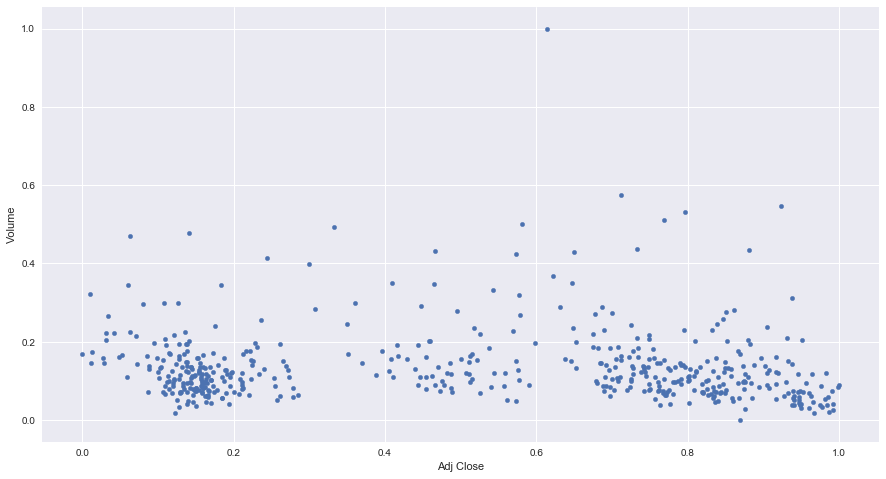

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler_volume = MinMaxScaler(copy=True, feature_range=(0, 1))
scaler_price = MinMaxScaler(copy=True, feature_range=(0, 1))

prices = stock.pricing_info.copy()

prices = prices.drop(labels=['Open', 'High', 'Low', 'Close', 'dates', 'timeline'], axis=1)

scaler_volume.fit(prices['Volume'].reshape(-1, 1))
scaler_price.fit(prices['Adj Close'].reshape(-1, 1))

prices['Volume'] = scaler_volume.transform(prices['Volume'].reshape(-1, 1))
prices['Adj Close'] = scaler_price.transform(prices['Adj Close'].reshape(-1, 1))

print("\nCorrelation between Volume and Prices:")
display(prices.corr())
prices.plot(kind='scatter', x='Adj Close', y='Volume')

## Exploratory Visualization


Now let's explore the historical pricing .. For that purpose, we have built two special purpose functions into the StockRegressor class. 

The first plotting function will show the "learning_df" DataFrame. This is the dataframe that will be used to store all "workspace" data, i.e. dates, indexes, prices, predictions of multiple algorithms. 

The second plotting function which will be less frequently used is a function that plots prices with the Bollinger bands. This is for pricing exploration only. 

Below, we call those two functions. As we haven't trained the StockRegressor, the plot_learning_data_frame() function will show the learning_df dataframe with only the pricing, and a vertical red line which marks the end of the "training" period at a "cutoff" date, after which, a prediction by the various algorithms will be made, i.e. testing period. 

This "cutoff" date corresponds to the end date supplied in the StockRegressor constructor. The StockRegressor instance will also make sure to get a few days ahead of the end of the testing phase, just for plotting purposes, to see the trend of the prices even beyond the testing period. 

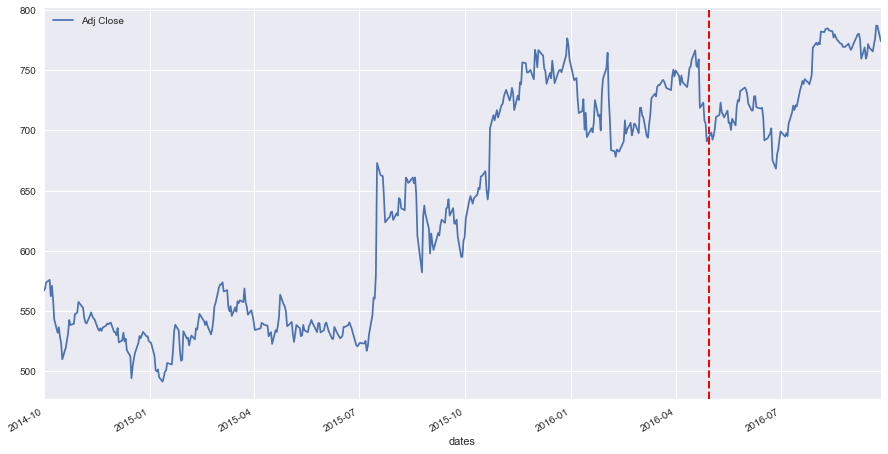

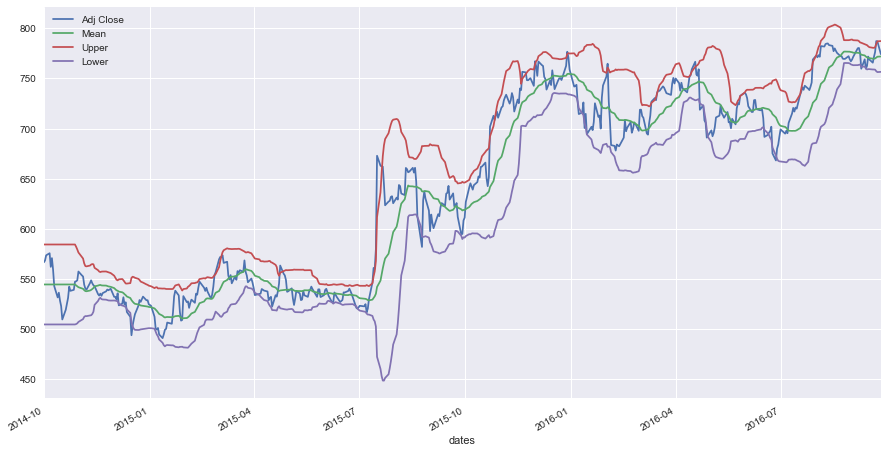

In [5]:
stock.plot_learning_data_frame()
stock.plot_bollinger_bands()

### Features to be Used for the Prediction

Since stock price is really a time series, then there is really not many features that could be used for predictions, and for training the ML models. In fact, all there is to feed the ML model for prediction is the date. 

Now for advanced techniques, some ML algos can take advantage of the stock news (ML sentiment analysis), to learn if the news is positive or negative, and how it will affect pricing, maybe using Reinforcement Learning.

Another area of exploration for ML models, is the "Fundamental Analysis" valuation techniques of the company stocks. With the fundamental analysis valuation, an analyst can deduce how the stock should be priced in an ideal world - given past cash flow of dividends, or capital gains / price appreciation in the case of no dividends. Therefore, the analyst can deduce if a stock is currently under-priced or over-priced given its valuation. This categorization or "fundamental price" can then be used as an input feature, in addition to the date input feature for future prediction.

In this project, I will not be exploring news or fundamental analysis. All that will be done is to predict the future prices based solely on the date. That means that this ML model will have only one feature which is the date (or an integer timeline index).



---

## Algorithms and Techniques





In this section, we will be discussing the algorithms and techniques used for forecasting the stock pricing. 

Given that we have only one input feature for prediction which is the date, then in the StockRegressor implementation, the following algorithms and technique have been implemented:

* **Linear Regression of polynomial order**: regressions of multiple polynomial orders (1, 2, 3, etc..) can be trained in this model. The model has parametrized the polynomial order and the number of regressions, and therefore multiple regressions of differing polynomial orders can be run at the same time.


* **Recurrent Neural Network**: a simple RNN has been implemented, to see how it compares to the linear regressions. The concept behind the RNN is that, if the stock displays a certain "pattern" in the time series, then the RNN will learn it - and remember it, and will use it for prediction. In this project however, and since the ML Nanodegree does not cover RNNs, I tried to keep this at a basic introductory level, to be explored in future work. I have used the basic publicly listed model created by Siraj Raval, with the reference included below.


* **Market Momentum**: stock prices seem to be a function of the overall trend of the stock (i.e. regression over a long period, like the last year or two), as well as the market momentum for that stock that spans only the last few days (10 - 30 days range). Therefore a regression over only the last few days before the first prediction/testing date will indicate where the market is moving, and which direction the momentum is. A combination of the two regressions (long-term regression and momentum) will therfore give a better prediction. 


* **Fast Fourier Transform**: FFT is implemented here as an exploratory technique, to see if the stock prices display some harmonics, and which can be used to "lock in" on the price fluctuation. The FFT is applied on the de-trended data (real prices minus the regression), and re-constructed in a similar manner (using the FFT harmonics to construct predictive fluctuation, and then adding the underlying trend - or regression - again to give the total prediction price).


* **Grid Search**: grid search will be used to optimize the hyper-parameters of the StockRegressor. There are lots of parameters that could be fine-tuned, such as how many regressions of different orders to use, or how many days to use for the momentum regression, etc..




---

# Methodology

## Data Preprocessing

What we do for preprocessing is minimal, since we only have one input feature which is the date. For that we create an integer "index" out of the dates, that is really just an incrementing counter, and we call it "timeline".

The next step would be to eliminate all the columns that are not needed. The columns 'Open', 'High', 'Low', 'Close' will all be discarded, because we will be working with the 'Adj Close' prices only, and store the result into a DataFrame called 'adj_close_price'. The 'adj_close_price', and the 'learning_df' are the two main dataframes which will be used all throughout the StockRegressor class.

Below is a glimpse of 'adj_close_price' ...



In [6]:
display(stock.adj_close_price.head())

,Adj Close,dates,timeline
timeline,,,
0,566.714111,2014-10-01,0
1,568.519104,2014-10-02,1
2,573.704895,2014-10-03,2
3,575.769226,2014-10-06,3
4,562.196472,2014-10-07,4


Let's see how 'learning_df' looks before training ... 



> **Note:** In the 'learning_df' dataframe, you can see that there's a column called 'Rolling Mean-60'. This has been generated and used by the Bollinger graph plotting function, and is not really used in the ML models. 



In [7]:
display(stock.learning_df.head())

,Adj Close,dates,timeline,Rolling Mean-60
timeline,,,,
0,566.714111,2014-10-01,0,537.17319
1,568.519104,2014-10-02,1,537.17319
2,573.704895,2014-10-03,2,537.17319
3,575.769226,2014-10-06,3,537.17319
4,562.196472,2014-10-07,4,537.17319


## Implementation

### Exploring Recurrent Neural Networks 

Let's explore first the Recurrent Neural Network ML aglorithm. This model has been created by Siraj Raval, and has been replicated below to forecast stock prices. Please note that the exploration of RNNs here is very superficial, since I'm also enrolled in the Deep Learning Nanodegree, and haven't yet covered RNNs. 

The model consists of two layers of LSTM nodes, the first having 50 input nodes with return_sequences set to True, and the second layer of 100 nodes. The model then has a 3rd layer of one Dense node that will output the prediction. The 50 input nodes means that the RNN will take in frames of 50 values from the time series, then the next input will be the same frame but shifted left, with a most recent price value inserted at the end of the frame. This way the RNN will try to "remember" sequences of values in the time series. 

For yielding RNN predictions, one 50-sample frame is taken, and is used to generate one forecast value. This forecast value is then inserted into the end of the 50-sample frame (after left shifting), and then re-fed into the RNN. This is kept on, until all values in the 50-sample frame are forecasted values, and not real prices. This 50-sample frame is then plotted below.

Below will be displayed the prediction graph of the RNN, in addition to the R^2 scores. 

> **Note**: here's the references:
* https://github.com/vsmolyakov/experiments_with_python/blob/master/chp04/keras_lstm_series.ipynb
* https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb


> **Note**: from the graph plotted below, the RNN doesn't seem to yield a great forecast (it probably depends on the limited training data that was given below), and given my limited understanding of RNNs, neural networks will not be investigated further in this project. Therefore, any data generated by the RNN processing or prediction will not be stored in the 'learning_df' dataframe



Getting pricing information for GLD for the period 2014-01-01 to 2017-08-15
Found a pricing file with wide range of dates, reading ... Stock-GLD-1999-01-01-2018-01-31.csv 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 

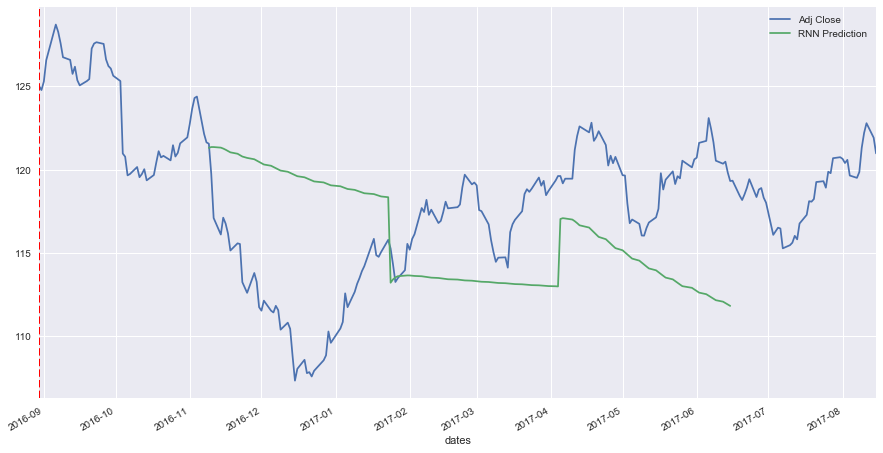

In [6]:
stock_rnn = StockRegressor('GLD', dates=  ['2014-01-01', '2016-08-30'], n_days_to_read_ahead = 350)
stock_rnn.trainRNN()
scores = stock_rnn.score_RNN(verbose = True)
y = stock_rnn.predictRNN(start_date = stock_rnn.training_end_index, plot_prediction = True)

Although for a different time range, the RNN seems to be doing a little bit better ...

Getting pricing information for GLD for the period 2010-01-01 to 2014-12-17
Found a pricing file with wide range of dates, reading ... Stock-GLD-1999-01-01-2018-01-31.csv 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 

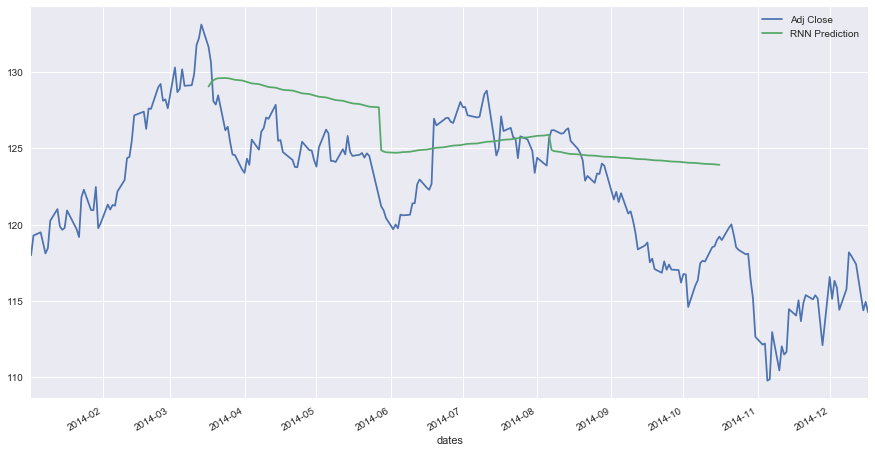

In [7]:
stock_rnn = StockRegressor('GLD', dates= ['2010-01-01', '2014-01-01'], n_days_to_read_ahead = 350)
stock_rnn.trainRNN()
scores = stock_rnn.score_RNN(verbose = True)
y = stock_rnn.predictRNN(start_date = stock_rnn.training_end_index, plot_prediction = True)

### Exploring Regressions

Now let's run our first regression, and see how it will look like ....

In [8]:
stock.trainRegression(poly_degree = 1, verbose=True)

Regression Model Coefficients of Poly degree 1: [ 0.          0.68139685]
Regression Model Intercept of Poly degree 1: 480.88633159844323


Another look at 'learning_df' ... and we can see that there's a new column called 'Linear Regression Order 1'.

Let's also plot learning_df to see how the linear regression of order 1 is doing relative to the real prices. You will notice that the regression is also predicting the first 50 "trading days" after the cutoff date delimited by the vertical dashed line, which also corresponds to the end of the training period. 

A default value of 50 trading days for prediction is used throughout this project, although this can be changed at any time, since it is parametrized. 

> **Note**: At a first glance, the linear regression of order 1 is not doing great predicting the testing period prices. 

,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1
timeline,,,,,
0,566.714111,2014-10-01,0,537.17319,480.886332
1,568.519104,2014-10-02,1,537.17319,481.567728
2,573.704895,2014-10-03,2,537.17319,482.249125
3,575.769226,2014-10-06,3,537.17319,482.930522
4,562.196472,2014-10-07,4,537.17319,483.611919


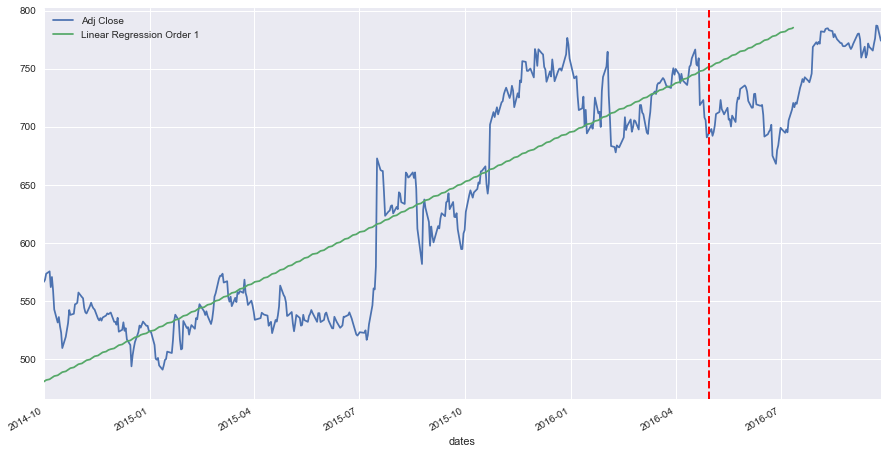

In [9]:
display(stock.learning_df.head())
stock.plot_learning_data_frame()

Let's add another regression of order 2 ... and see how it will look like.

> **Note**: The linear regression of order 2 is not doing great forecasting prices either ...

Regression Model Coefficients of Poly degree 2: [ 0.          0.15435083  0.00132757]
Regression Model Intercept of Poly degree 2: 515.6713690993323


,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2
timeline,,,,,,
0,566.714111,2014-10-01,0,537.17319,480.886332,515.671369
1,568.519104,2014-10-02,1,537.17319,481.567728,515.827048
2,573.704895,2014-10-03,2,537.17319,482.249125,515.985381
3,575.769226,2014-10-06,3,537.17319,482.930522,516.146370
4,562.196472,2014-10-07,4,537.17319,483.611919,516.310014


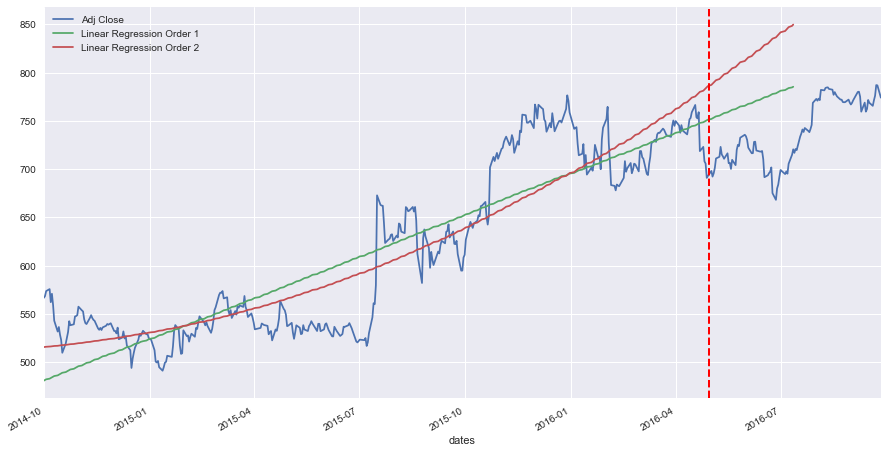

In [10]:
stock.trainRegression(poly_degree = 2, verbose=True)
display(stock.learning_df.head())
stock.plot_learning_data_frame()

Adding linear regression of order 3 ...

> **Note**: The linear regression of order 3 seems to be doing better when it comes to predicting future prices. 

Regression Model Coefficients of Poly degree 3: [  0.00000000e+00  -1.67574063e+00   1.28665856e-02  -1.93770172e-05]
Regression Model Intercept of Poly degree 3: 575.8357868560126


,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2,Linear Regression Order 3
timeline,,,,,,,
0,566.714111,2014-10-01,0,537.17319,480.886332,515.671369,575.835787
1,568.519104,2014-10-02,1,537.17319,481.567728,515.827048,574.172893
2,573.704895,2014-10-03,2,537.17319,482.249125,515.985381,572.535617
3,575.769226,2014-10-06,3,537.17319,482.930522,516.146370,570.923841
4,562.196472,2014-10-07,4,537.17319,483.611919,516.310014,569.337450


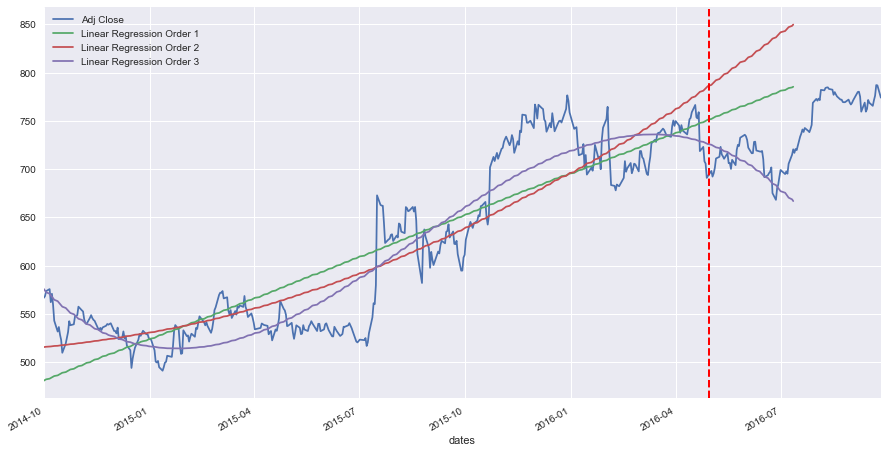

In [11]:
stock.trainRegression(poly_degree = 3, verbose=True)
display(stock.learning_df.head())
stock.plot_learning_data_frame()

### Exploring Market Momentum

We will explore now the market momentum and how it can be added to our model. 

Let's first see how different dates will affect the momentum regression, which is a regression based on the few days earlier than the forecast date (first forecast date shown below as the red vertical dashed line).

However, below we show that for the same forecast date/testing period, the market momentum regression will take wildly different values, depdending on the number of days used for the regression. The number of days look like a good candidate for hyper-parametrization. 


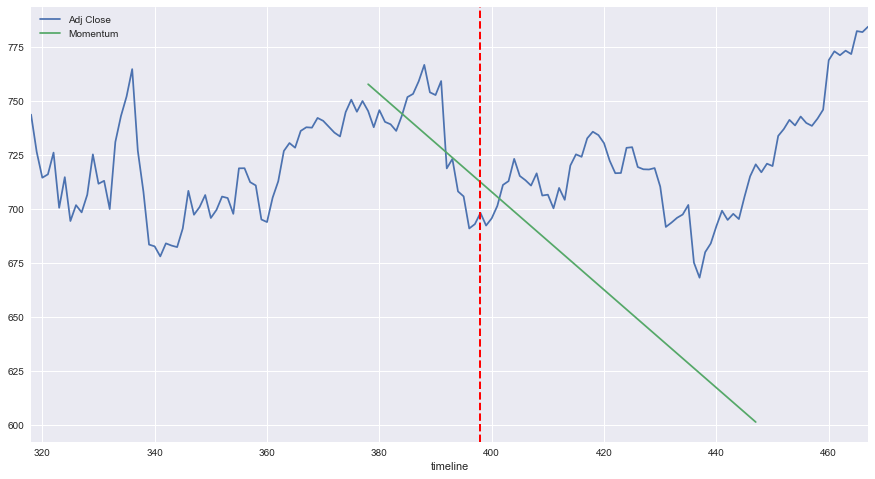

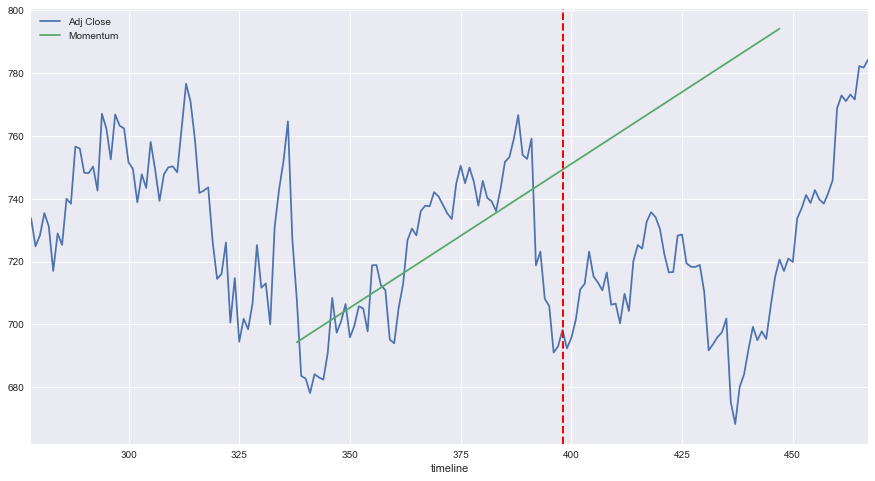

In [12]:
def plot_momentum(stock, n_days_for_regression = 20):
    
    momentum_polyfit = np.polyfit(stock.X_train[-n_days_for_regression:], 
                                  stock.y_train[-n_days_for_regression:], 1)
            
    momentum_trend_x = np.concatenate((stock.X_train[stock.training_end_index- n_days_for_regression:],
                                       stock.X_test), axis=0)
        
    momentum_linear_reg_o1 = momentum_polyfit[1] + momentum_polyfit[0] * momentum_trend_x   
    
    prices = pd.DataFrame(stock.adj_close_price['Adj Close'][stock.training_end_index- n_days_for_regression - 60:\
                                                                            stock.testing_end_index + 20])
    prices['Momentum'] =  np.nan
    prices['Momentum'][60:-20] = momentum_linear_reg_o1

    prices.plot()
    plt.axvline(stock.training_end_index, color='r', linestyle='dashed', linewidth=2)
    plt.show()
    
plot_momentum(stock, n_days_for_regression = 20)
plot_momentum(stock, n_days_for_regression = 60)

Adding the market momentum of the last 30 trading days to the regressions, will look like the following.

,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2,Linear Regression Order 3,Momentum
timeline,,,,,,,,
396,691.020020,2016-04-28,396,721.881335,750.719485,784.978804,726.632958,726.248396
397,693.010010,2016-04-29,397,721.315669,751.400882,786.185919,726.021502,725.375215
398,698.210022,2016-05-02,398,NaN,752.082279,787.395690,725.389622,724.502034
399,692.359985,2016-05-03,399,NaN,752.763676,788.608115,724.737204,723.628853


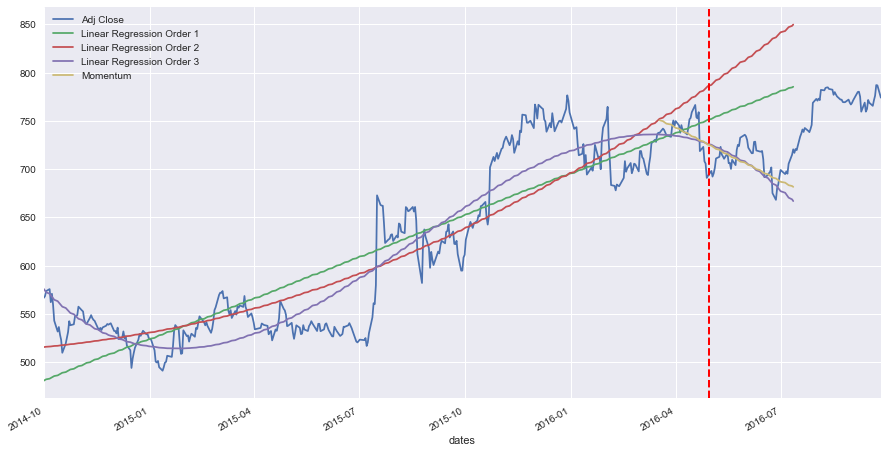

In [13]:
stock.trainMomentum(days_for_regression = 30, verbose = True )
display(stock.learning_df[stock.training_end_index -2:stock.training_end_index + 2])
stock.plot_learning_data_frame()

### An Observation ...


Running the above regressions and momentum regression countless times on multiple stocks and multiple dates, yields an interesting observation. In most cases (but not all), the real stock prices in the forecasting / testing period seem to be "bounded" by the regressions of order 1, 2, 3 and the market momentum. In the majority of cases, this holds true.

The below will illustrate this for a different stock (or commodity in this case - Gold).

> **Note:** This is of course true given that the training period is big enough - something around 1.5 - 2 years or between 400 and 500 samples of trading days. If the training is too short, then the regressions of higher order (2 and 3) will curve sharply upwards or downwards in the testing period. 

Getting pricing information for GLD for the period 2014-10-01 to 2016-10-29
Found a pricing file with wide range of dates, reading ... Stock-GLD-1999-01-01-2018-01-31.csv 


,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2,Linear Regression Order 3,Momentum
timeline,,,,,,,,
417,115.620003,2016-05-27,417,119.389167,111.351181,118.626410,125.831826,118.947761
418,116.059998,2016-05-31,418,119.314501,111.343483,118.724663,126.143046,118.863249
419,115.940002,2016-06-01,419,NaN,111.335786,118.823423,126.457341,118.778738
420,115.669998,2016-06-02,420,NaN,111.328089,118.922692,126.774722,118.694226


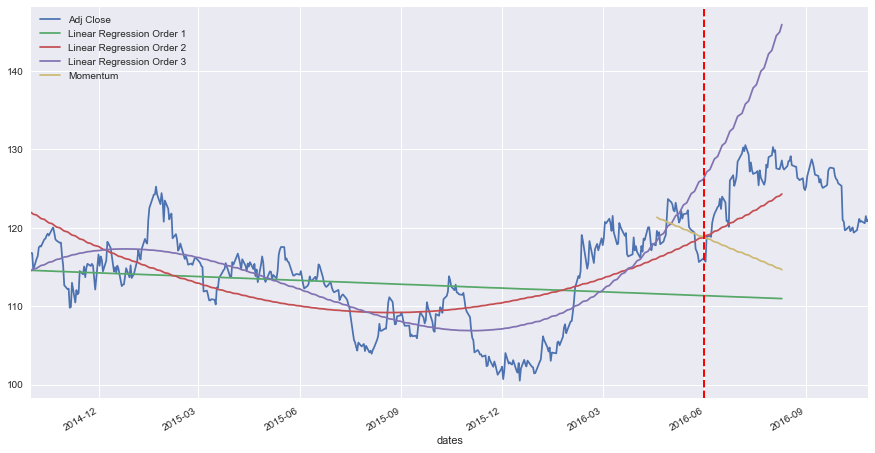

In [14]:
stock2 = StockRegressor('GLD', dates=['2014-10-01', '2016-06-01'])
stock2.trainRegression(poly_degree = 1, verbose=False)
stock2.trainRegression(poly_degree = 2, verbose=False)
stock2.trainRegression(poly_degree = 3, verbose=False)
stock2.trainMomentum(days_for_regression = 30, verbose=False)
display(stock2.learning_df[stock2.training_end_index -2:stock2.training_end_index + 2])
stock2.plot_learning_data_frame()

## Refinement

### A New Approach ...

Therefore, to act on the above observation, it stands to reason to combine the regressions and market momentum regression into a new approximation, that will yield a better forecast. 

After testing and trialing this, it looks like averaging the regressions of orders 1, 2, and 3, and then splitting this average with the market momentum regression seems to yield somewhat good results. The equation of the new model becomes: 

**New Reg/Momentum** = momentum_split x market momentum + (1 - momentum_split) x average regressions(orders 1, 2, and 3)

The below will do just that. From now onwards, this approach will be labeled as the "Regression/Momentum" model. 



,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2,Linear Regression Order 3,Momentum,Prediction Reg/Momentum
timeline,,,,,,,,,
396,691.020020,2016-04-28,396,721.881335,750.719485,784.978804,726.632958,726.248396,742.965608
397,693.010010,2016-04-29,397,721.315669,751.400882,786.185919,726.021502,725.375215,742.871747
398,698.210022,2016-05-02,398,NaN,752.082279,787.395690,725.389622,724.502034,742.774332
399,692.359985,2016-05-03,399,NaN,752.763676,788.608115,724.737204,723.628853,742.673340


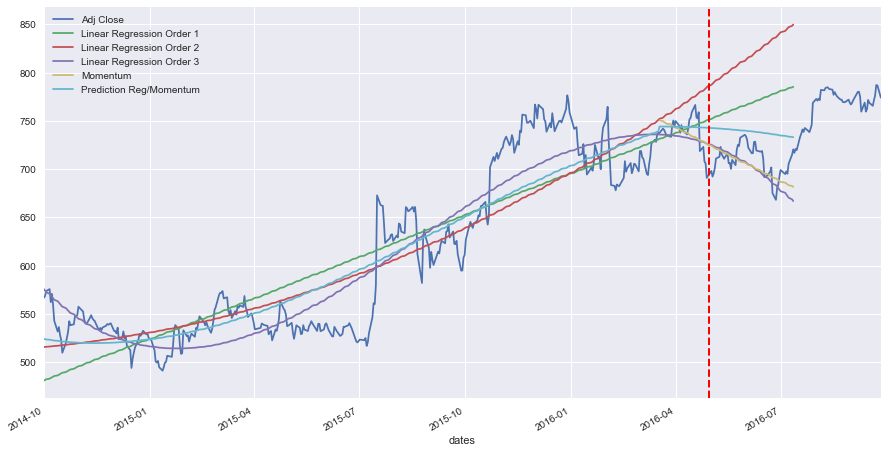

In [15]:
stock.trainAverageMomentum(momentum_split = 0.4, verbose = False)
display(stock.learning_df[stock.training_end_index -2:stock.training_end_index + 2])
stock.plot_learning_data_frame()

### Exploring Fast Fourier Transform

The whole point of exploring the FFT transform was to investigate whether the price time series has some reliable fluctuation "pattern", that could be used to predict fluctuation. This is done by applying FFT on the de-trended data, and then getting the N strongest FFT frequencies. Then, similar to applying the inverse FFT, we calculate the phase and amplitude of these N frequencies, and use them on the testing period as forecast. We can then add the underlying price, to create the overall prediction. 

During the training period, the underlying trend is provided by one of the regressions trained above. Usually, after many trials, the regression of order 3 performs well with the FFT. 

During the testing period, we add this to the "Regression/Momentum" model trained above, which is the average of the market momentum and the avereage values of all regressions.

> **Note:** Please note that since the FFT will need to operate on de-trended data (oscillating data around 0), then the other regressions need to be trained before using the trainFFT() function. We also need to train the momentum since the de-trended 

,Adj Close,dates,timeline,Rolling Mean-60,Linear Regression Order 1,Linear Regression Order 2,Linear Regression Order 3,Momentum,Prediction Reg/Momentum,Prediction w/FFT
timeline,,,,,,,,,,
0,566.714111,2014-10-01,0,537.17319,480.886332,515.671369,575.835787,NaN,524.131163,501.446744
1,568.519104,2014-10-02,1,537.17319,481.567728,515.827048,574.172893,NaN,523.855890,500.498907
2,573.704895,2014-10-03,2,537.17319,482.249125,515.985381,572.535617,NaN,523.590041,500.336438
3,575.769226,2014-10-06,3,537.17319,482.930522,516.146370,570.923841,NaN,523.333578,500.786457
4,562.196472,2014-10-07,4,537.17319,483.611919,516.310014,569.337450,NaN,523.086461,501.622055


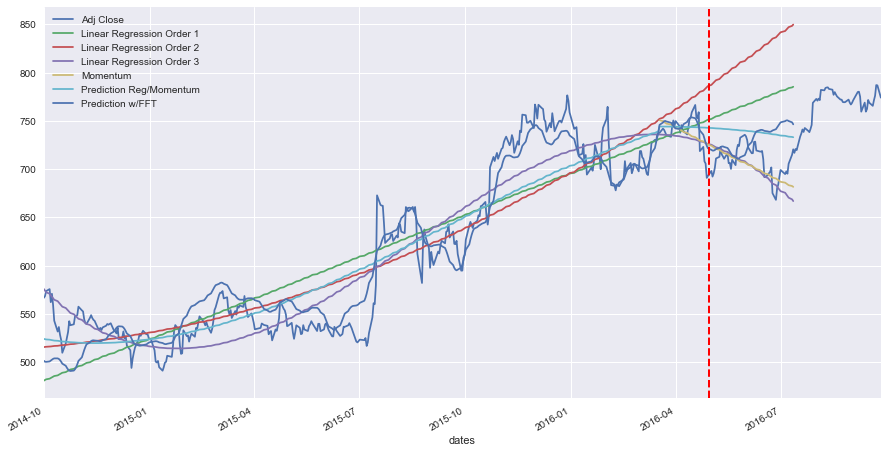

In [16]:
stock.trainFFT(num_harmonics = 6, underlying_trend_poly = 3, verbose = True)
display(stock.learning_df.head())
stock.plot_learning_data_frame()

# Results

## Model Evaluation and Validation

### Predicting and Scoring

The below two functions will predict and score all the approaches, and will give also the percent change of each. 

The predict() function will also yield predictions for the first day after the training period, the 7th day, the 15th day, the 22nd day, and so ... until the 50th day. These predictions are all in the testing period, and the model only takes as input only one feature, which is the date (or timeline index). 




In [17]:
stock.score(verbose = True)
stock.predict()


--------------------------------------------------------------
R^2 Score of Linear Regression of Poly order 1 Training: 0.79
R^2 Score of Linear Regression of Poly order 1 Testing: -16.30
R^2 Score of Linear Regression of Poly order 2 Training: 0.82
R^2 Score of Linear Regression of Poly order 2 Testing: -53.52
R^2 Score of Linear Regression of Poly order 3 Training: 0.89
R^2 Score of Linear Regression of Poly order 3 Testing: -0.75
R^2 Score of Reg/Momentum Training: 0.85
R^2 Score of Reg/Momentum Testing: -3.81
R^2 Score of FFT Training: 0.93
R^2 Score of FFT Testing: -3.52
--------------------------------------------------------------


Training End date: 2016-04-30
First Day of Prediction: 2016-05-02


,Day,Index,Date,Adj Close,Reg/Mom Pred,FFT Prediction,Reg1 Pred,Reg2 Pred,Reg3 Pred,Reg/Mom Pct Var %,FFT Pct Var %,Reg1 Pct Var %,Reg2 Pct Var %,Reg3 Pct Var %
0,1,398,2016-05-02,698.21,742.77,720.09,752.08,787.40,725.39,6.38,3.13,7.72,12.77,3.89
1,8,403,2016-05-09,712.90,742.23,721.97,755.49,793.48,721.92,4.11,1.27,5.97,11.30,1.27
2,15,408,2016-05-16,716.49,741.60,722.01,758.90,799.64,717.92,3.50,0.77,5.92,11.61,0.20
3,22,413,2016-05-23,704.24,740.87,712.35,762.30,805.86,713.38,5.20,1.15,8.24,14.43,1.30
4,29,418,2016-05-31,735.72,740.04,714.54,765.71,812.15,708.28,0.59,-2.88,4.08,10.39,-3.73
5,36,422,2016-06-06,716.55,739.31,728.18,768.44,817.23,703.80,3.18,1.62,7.24,14.05,-1.78
6,43,427,2016-06-13,718.36,738.30,740.31,771.84,823.63,697.66,2.78,3.06,7.45,14.65,-2.88
7,50,432,2016-06-20,693.71,737.18,739.17,775.25,830.11,690.92,6.27,6.55,11.75,19.66,-0.40



Mean Regression/Momentum Prediction Percent Variation: +/- 4.00%
Mean FFT Prediction Percent Variation: +/- 2.56%
Mean Regression Order 1 Prediction Percent Variation: +/- 7.30%
Mean Regression Order 2 Prediction Percent Variation: +/- 13.61%
Mean Regression Order 3 Prediction Percent Variation: +/- 1.93%


### Grid Search

Given that we have quite a few parameters to feed the model, it was worthwhile to implement a grid-search function, that will use these "hyper-parameters" to fine-tune them and get the highest scoring possible. 

Although reliably predicting stock prices is an impossible task, but the intuition here is that every stock has a different volatility relative to the market (stock beta), different set of news, different divident payout cycles and so on. And therefore, each stock would have their own "hyper-parameters" tuned to the best of this stock only, and nothing else. 

The hyper-parameters that were implemented are:

* Number of harmonics: the number of highest-power harmonics to be used in the FFT model 
* Momentum Split: the split between the market momentum regression, and the average of all regressions
* Days for Regression: the number of days to use to calculate the momentum regression, immediately preceding the forecast date
* Underlying Trend Poly: this is the polynomial order of the regression used for the underlying trend used by the FFT model to "de-trend" the data and apply the FFT on the resulting residual

Default values of the hyper-parameters are: 

* Regressions: regressions of polynomial order 1, 2, and 3 are implemented
* Number of harmonics: default is set to 4
* Underlying Trend Poly of order 3 is used for the FFT de-trending
* Days for Regression: the default is set to 15
* Momentum Split: the default is set to 0.25


One more hyper-parameter that I haven't listed above is the "Training Delta Months": for the same combination of the above hyperparameters (harmonics, momentum split, days for regression, and poly of underlying trend), repeat the predictions as a sliding window going back in time one month at a time, before the end training period. The R^2 scores are then averaged for each combination of these hyper-parameters over the total number of months. 


To illustrate all the hyper-parameters that could be set, the below stock is created, and predicted.

Getting pricing information for GLD for the period 2014-10-01 to 2016-11-16
Found a pricing file with wide range of dates, reading ... Stock-GLD-1999-01-01-2018-01-31.csv 
Training end date is 2016-04-30, corresponding to the 398th sample
The data has 398 training samples and 140 testing samples with a total of 538 samples
Training set has 398 samples.
Testing set has 50 samples.
Regression Model Coefficients of Poly degree 1: [ 0.        -0.0150657]
Regression Model Intercept of Poly degree 1: 115.55606908425585
Regression Model Coefficients of Poly degree 2: [ 0.         -0.10540178  0.00022755]
Regression Model Intercept of Poly degree 2: 121.51825035399823
Regression Model Coefficients of Poly degree 3: [  0.00000000e+00   1.40551596e-01  -1.32322782e-03   2.60415553e-06]
Regression Model Intercept of Poly degree 3: 113.4325114891368

--------------------------------------------------------------
R^2 Score of Linear Regression of Poly order 1 Training: 0.10
R^2 Score of Linear Regr

,Day,Index,Date,Adj Close,Reg/Mom Pred,FFT Prediction,Reg1 Pred,Reg2 Pred,Reg3 Pred,Reg/Mom Pct Var %,FFT Pct Var %,Reg1 Pct Var %,Reg2 Pct Var %,Reg3 Pct Var %
0,1,398,2016-05-02,123.24,118.04,118.46,109.56,115.61,123.95,-4.22,-3.88,-11.10,-6.19,0.57
1,8,403,2016-05-09,120.65,118.76,119.44,109.48,116.00,125.61,-1.56,-1.00,-9.25,-3.86,4.12
2,15,408,2016-05-16,121.80,119.51,119.98,109.41,116.39,127.38,-1.88,-1.50,-10.17,-4.44,4.58
3,22,413,2016-05-23,119.37,120.28,120.14,109.33,116.80,129.23,0.76,0.65,-8.41,-2.15,8.26
4,29,418,2016-05-31,116.06,121.07,120.16,109.26,117.22,131.18,4.31,3.53,-5.86,1.00,13.03
5,36,422,2016-06-06,118.92,121.71,120.22,109.20,117.56,132.81,2.35,1.10,-8.17,-1.14,11.68
6,43,427,2016-06-13,122.64,122.54,120.52,109.12,118.00,134.93,-0.08,-1.73,-11.02,-3.78,10.02
7,50,432,2016-06-20,123.21,123.39,121.12,109.05,118.45,137.16,0.14,-1.70,-11.49,-3.86,11.32



Mean Regression/Momentum Prediction Percent Variation: +/- 1.91%
Mean FFT Prediction Percent Variation: +/- 1.88%
Mean Regression Order 1 Prediction Percent Variation: +/- 9.44%
Mean Regression Order 2 Prediction Percent Variation: +/- 3.30%
Mean Regression Order 3 Prediction Percent Variation: +/- 7.95%


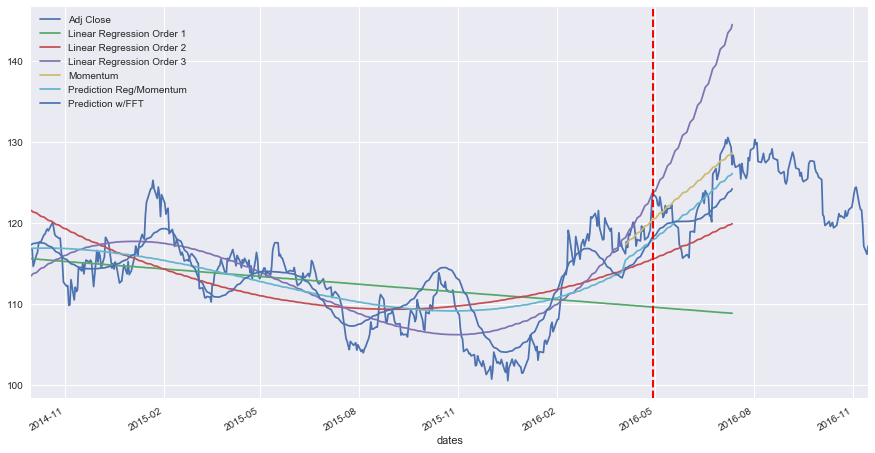

In [19]:
s = StockRegressor('GLD',  dates = ['2014-10-01', '2016-04-30'], n_days_to_read_ahead=200)
s.train(num_harmonics = 4, momentum_split = 0.4, days_for_regression = 20, underlying_trend_poly=3, 
                                       poly_degree = [1, 2, 3])
s.score(verbose=True)
s.predict()
s.plot_learning_data_frame()


### Running the Grid Search

The below will then run the grid search over the Google stock for the same period, and see if it will beat the 4% pct variation for the Reg/Momentum model, or the 2.56% pct variation for the Reg/Momentum combined with the FFT model, with the default values of the hyper-parameters.

It is worth mentioning that the R^2 scores of the Regression/Momentum model and of the FFT model for each iteration will be saved, and then averaged, and searched for the maximum R^2 score, which will be used to find the best combination of hyper-parameters.

Total Sample Size: 502 samples
Training Sample Size: 348 samples
Training Window: 347 samples
Validation Window: 50 samples
Testing Sample Size: 50 samples
Training End Date is 2016-03-31 corresponding to the 347th sample
Validation End Index 397 over range 0 - 347 with validation window 50
There are 384 combinations with 1 iterations each: total iterations is 384

Progress:
Iteration Progress: 384 / 384

Hyper-Parameters:
Harmonics Hyperparamter: 12
Days Used for Momentum Regression Hyperparamter: 45
Regression Order for Underlying Trend for FFT Hyperparamter: 3
Momentum Split for Underlying Trend for FFT Hyperparamter: 0.8

Mean R^2 Scores:
Regression of Order 1: Training 0.60 | Validation 0.13
Regression of Order 2: Training 0.88 | Validation -39.62
Regression of Order 3: Training 0.88 | Validation -27.97
Regression of Order 3 with Momentum: Training 0.87 | Validation -1.45
FFT with Underlying Trend of Regression of Order 3: Training 0.94 | Validation -1.31


Model took 217.94 secon

,Day,Index,Date,Adj Close,Reg/Mom Pred,FFT Prediction,Reg1 Pred,Reg2 Pred,Reg3 Pred,Reg/Mom Pct Var %,FFT Pct Var %,Reg1 Pct Var %,Reg2 Pct Var %,Reg3 Pct Var %
0,1,398,2016-05-02,698.21,732.75,725.51,752.08,787.40,725.39,4.95,3.91,7.72,12.77,3.89
1,8,403,2016-05-09,712.90,725.23,750.14,755.49,793.48,721.92,1.73,5.22,5.97,11.30,1.27
2,15,408,2016-05-16,716.49,717.62,735.73,758.90,799.64,717.92,0.16,2.69,5.92,11.61,0.20
3,22,413,2016-05-23,704.24,709.91,724.13,762.30,805.86,713.38,0.81,2.82,8.24,14.43,1.30
4,29,418,2016-05-31,735.72,702.10,730.35,765.71,812.15,708.28,-4.57,-0.73,4.08,10.39,-3.73
5,36,422,2016-06-06,716.55,695.79,726.02,768.44,817.23,703.80,-2.90,1.32,7.24,14.05,-1.78
6,43,427,2016-06-13,718.36,687.79,705.85,771.84,823.63,697.66,-4.25,-1.74,7.45,14.65,-2.88
7,50,432,2016-06-20,693.71,679.70,689.62,775.25,830.11,690.92,-2.02,-0.59,11.75,19.66,-0.40



Mean Regression/Momentum Prediction Percent Variation: +/- 2.67%
Mean FFT Prediction Percent Variation: +/- 2.38%
Mean Regression Order 1 Prediction Percent Variation: +/- 7.30%
Mean Regression Order 2 Prediction Percent Variation: +/- 13.61%
Mean Regression Order 3 Prediction Percent Variation: +/- 1.93%


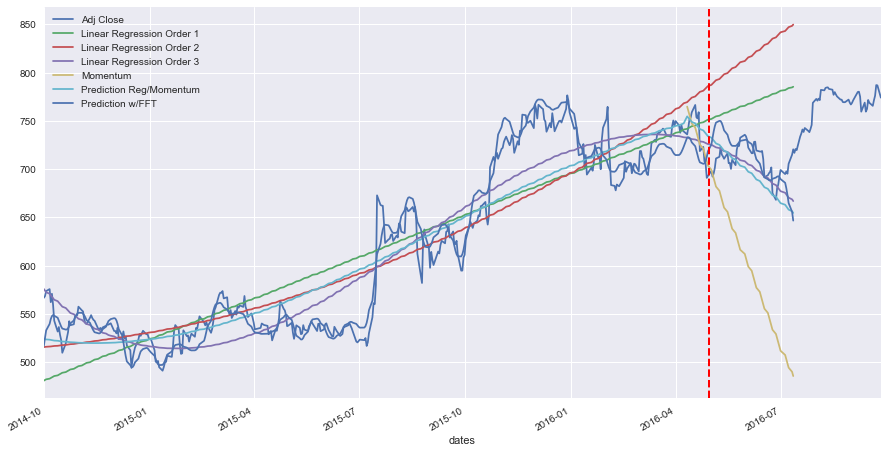

In [3]:
gs = StockGridSearch(ticker = 'GOOG', dates= ['2014-10-01', '2016-04-30'], training_delta_months = 3)
gs.train(n_days_to_predict = 50, 
         num_harmonics = [2, 4, 6, 12],
         days_for_regression = [15, 25, 35, 45],
         poly_degree = [1, 2, 3],
         underlying_trend_poly = [2, 3], 
         momentum_split = [0.2, 0.4, 0.6, 0.8])

## Benchmarking

Regressions of polynomial orders 1 and 3, as well as ARIMA will be used to benchmark this Regress/Momentum model. 

The Mean-Square-Error will be calculated over a period of 7 years, with a space of 30 days (therefore every month or 84 iterations). The MSE will be calculated by comparing the forecast over 50 days after the end of the training day, with the actual testing prices. 

In [18]:
def pr(ticker='GOOG', dates = ['2013-01-01', '2014-09-30'], verbose = True, r = 15, ms = 0.25):
    stock = StockRegressor(ticker,  dates = dates, n_days_to_read_ahead=250, 
                               n_days_to_predict = 50, verbose = False)

    series = stock.adj_close_price.copy()
    series.index = series['dates']
    series = series.drop(labels=['dates', 'timeline'], axis=1)

    res_pd = pd.DataFrame(series)

    if verbose == True:
        print("\nTraining End Index {}".format(stock.training_end_index))
        print("Length of Learning DF {}".format(len(stock.learning_df)))

    history = list(series['Adj Close'][:stock.training_end_index])

    orig_training_end_index = stock.training_end_index

    res_pd['ARIMA'] = np.nan
    res_pd['Reg/Mom'] = np.nan
    res_pd['Reg 1'] = np.nan
    res_pd['Reg 3'] = np.nan
    predictions = list()

    itrts = 50

    for t in range(1):#itrts):
        if verbose == True:
            print("\r t {}\r ".format(t))
            clear_output(wait=True) 

        model = ARIMA(history, order=(5,1,0))
        stock.training_end_index = orig_training_end_index + t
        stock.train(no_FFT = True, keep_indexes = True, verbose=False,  days_for_regression=r, 
                                    momentum_split=ms)

        model_fit = model.fit(disp=0)
        output = model_fit.forecast(steps=itrts)
        yhat = output[0]

        mom = stock.learning_df['Momentum'][orig_training_end_index:orig_training_end_index+itrts]
        regmom = stock.learning_df['Prediction Reg/Momentum']\
                                [orig_training_end_index:orig_training_end_index+itrts]
        
        avreg = stock.reg_average[orig_training_end_index:orig_training_end_index+itrts]

        res_pd['ARIMA'][orig_training_end_index:orig_training_end_index+itrts] = yhat
        res_pd['Reg/Mom'][orig_training_end_index:orig_training_end_index+itrts] = regmom
        
    error = mean_squared_error(series['Adj Close'][orig_training_end_index:orig_training_end_index+itrts], 
                                       res_pd['ARIMA'][orig_training_end_index:orig_training_end_index+itrts])
    error2 = mean_squared_error(series['Adj Close'][orig_training_end_index:orig_training_end_index+itrts], 
                                       res_pd['Reg/Mom'][orig_training_end_index:orig_training_end_index+itrts])
    
    res_pd['Reg 1'][orig_training_end_index:orig_training_end_index+itrts] = stock.reg_pred[1]\
                                [orig_training_end_index:orig_training_end_index+itrts]
    res_pd['Reg 3'][orig_training_end_index:orig_training_end_index+itrts] = stock.reg_pred[3]\
                                [orig_training_end_index:orig_training_end_index+itrts]

    error3 = mean_squared_error(series['Adj Close'][orig_training_end_index:orig_training_end_index+itrts], 
                                   res_pd['Reg 1'][orig_training_end_index:orig_training_end_index+itrts])
    error4 = mean_squared_error(series['Adj Close'][orig_training_end_index:orig_training_end_index+itrts], 
                                   res_pd['Reg 3'][orig_training_end_index:orig_training_end_index+itrts])
        
    print('Test MSE Reg/Mom: {} - {}: {:.2f}'.format(dates[0], dates[1], error2))
    print('Test MSE ARIMA: {} - {}: {:.2f}'.format(dates[0], dates[1], error))
    print('Test MSE Reg 1: {} - {}: {:.2f}'.format(dates[0], dates[1], error3))
    print('Test MSE Reg 3 {} - {}: {:.2f}'.format(dates[0], dates[1], error4))
    
    if verbose == True:
        pyplot.rcParams["figure.figsize"] = (15,8)
        res_pd[orig_training_end_index-5:orig_training_end_index+itrts*2].plot()

    clear_output(wait=True)
    
    return error, error2, error3, error4

arima_err_lst = []
momreg_err_lst = []
reg1_err_lst = []
reg3_err_lst = []

months = 84
s_date ='2007-01-01'
date_range = []

for i in range(months):
    
    s = datetime.datetime.strptime(s_date, "%Y-%m-%d") + datetime.timedelta(days=30 * i)
    e = datetime.datetime.strptime(s_date, "%Y-%m-%d") + datetime.timedelta(days=30 * i + 365 * 2)

    arima_err, momreg_err, reg1_err, reg3_err = pr(ticker='BMY', dates = [s.strftime("%Y-%m-%d"), 
                                                                           e.strftime("%Y-%m-%d")], 
                                                   r = 15, 
                                                   ms = 0.25, 
                                                   verbose = False)
    
    date_range = [s_date, e.strftime("%Y-%m-%d")] 
    arima_err_lst.append(arima_err)
    momreg_err_lst.append(momreg_err)
    reg1_err_lst.append(reg1_err)
    reg3_err_lst.append(reg3_err)

    
print("\n--------------------------------------------------------------")  
print("Means calculated monthly over the period of {}-{} with a training window of two years"\
                                                          .format(date_range[0], date_range[1]))
print("Mean Arima MSE: {:.2f}".format(np.mean(arima_err_lst)))
print("Mean Mom/Reg MSE: {:.2f}".format(np.mean(momreg_err_lst)))
print("Mean Reg O1 MSE: {:.2f}".format(np.mean(reg1_err_lst)))
print("Mean Reg O3 MSE: {:.2f}".format(np.mean(reg3_err_lst)))
print("--------------------------------------------------------------\n") 




--------------------------------------------------------------
Means calculated monthly over the period of 2007-01-01-2015-10-26 with a training window of two years
Mean Arima MSE: 4.94
Mean Mom/Reg MSE: 7.14
Mean Reg O1 MSE: 11.25
Mean Reg O3 MSE: 21.95
--------------------------------------------------------------



As shown above, the Regression/Momentum model performs much better to the Regression-only models, and performs very closely to the ARIMA model. 



# Conclusion 

## Reflection

After implementing the above models, there are multiple points worth mentioning:

* It is impossible to reliably predict stock market prices, but ML can provide good approximations and forecasting models (otherwise we'll all be millionaires, or equally rich, however this will play out ... )


* The above models (RNN, regressions of different orders, Regression/Momentum, and FFT) provide a good approximation, but depending on what could be considered "risk", might or might not be suitable for trading. If predicting stock market prices within plus/minus 5% is considered good enough, then the above models could be good enough.


* On average, after countless runs, Regression/Momentum seems to be the best model with the best results (R^2 scores). FFT adds too much variation, as there might not be a reliable and "predictable" set of harmonics of the stock price, or a pattern of cyclicality. 


* Grid search doesn't always yield the best results. This is because earlier historical data in the training period is not a guaranteed way to find the optimal set of hyper-parameters. The yielded "hyper-parameters" might be optimal for the training period, but not for the testing period. 


* One very frequent problem with predicting stock prices, is that pricing can significantly differ from one day to the next, sometimes with complete trend reversal. This might be in response to some positive or bad news, or a terrorist attack, or a quarterly financial report of the company that differed from the analysts expectations. Therefore, no matter the ML model, this will fail. 


* On the positive side, one observation is that next day forecasting - the day immediately after the end of the training period - seems to be more reliably predicted than the rest of the days. This stands to reason, since the market trend and momentum are very clear before that day (although might not be too useful in the context of stock trading). 


* R^2 scores are mostly negative, but even though they're negative, then the scores are still sorted to look for the maximum


---

## Improvement

Future work, and areas of improvement: 

* The above models could be combined with an ML model for news (sentiment analysis)


* The above models could be combined with the "Fundamental Analysis" approach to yield more reliable results


* The above models could be combined with the "buy or sell signals" that are commonplace among traders, like the price moving below the Bollinger band yields a buy signal for traders, therefore causing the prices to automatically go up. This could be yet another input feautre to the model.  


* RNN models could be investigated in-depth. It could be that RNN can uncover predictable "patterns" of sequences of pricing that FFT cannot uncover.


---

# Quality 

## References

The below are references used in this project:

* RNN: https://github.com/vsmolyakov/experiments_with_python/blob/master/chp04/keras_lstm_series.ipynb
* RNN: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb
* LSTMs: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Fourier: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
